In [1]:
library(data.table)
suppressPackageStartupMessages(require(png))

setwd("/frazer01/home/matteo/analysis/i2qtl_sv/ld")

In [23]:
ukbb = read.table("/publicdata/ukbiobank_20180801/ukbb2vcf/ukbb_files.txt", header = TRUE)

In [30]:
geneinfo            = read.table("/publicdata/gencode_v19_20151104/gene_info.tsv", header = TRUE)
geneinfo$feature_id = unlist(lapply(geneinfo$gene_id, function(x){unlist(strsplit(x, "\\."))[[1]]}))

In [36]:
eqtls_joint0          = fread("/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v2/top_hits_sv_snp_maf5_story.tsv", sep = "\t", header = TRUE, data.table = FALSE)
eqtls_joint           = unique(eqtls_joint0[, c("feature_id", "snp_id", "p_value", "beta", "beta_se", "top_hit_final_sig")])
colnames(eqtls_joint) = c("feature_id", "snp_id", "pval", "beta", "se", "egene")
eqtls_sv0             = fread("/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v2/all_qtls_combined_filt5.tsv"   , sep = "\t", header = TRUE, data.table = FALSE)
eqtls_sv              = unique(eqtls_sv0   [eqtls_sv0$top_hit_final_sig  == TRUE, c("feature_id", "NR_ID", "SVTYPE", "start_variant", "end_variant", "p_value", "beta", "beta_se")])
colnames(eqtls_sv   ) = c("feature_id", "sv_id", "svtype", "sv_start", "sv_end", "pval", "beta", "se")
eqtls_sv              = merge(eqtls_sv, eqtls_joint, by = "feature_id", suffixes = c("_svonly", "_joint"), all.x = TRUE)
eqtls_sv              = merge(eqtls_sv, geneinfo)
eqtls_sv$id2gene      = paste(eqtls_sv$snp_id, eqtls_sv$gene_id)

In [16]:
indata = fread(list.files("cpbayes", full.names = TRUE)[[1]], header = TRUE, sep = "\t", data.table = FALSE)

read_cpbayes = function(x, mycols)
{
    indata = fread(x, header = TRUE, sep = "\t", data.table = FALSE)
    if (length(colnames(indata)) < length(mycols))
    {
        indata$top = NA
        indata     = indata[,mycols]
    }
    
    #message(paste(x, length(colnames(indata)), length(mycols)))

    return(indata)
}

ld = rbindlist(lapply(list.files("cpbayes", full.names = TRUE), function(x){read_cpbayes(x, colnames(indata))}))

write.table(ld, "cpbayes_ld_data.txt", quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
lddata = as.data.frame(ld)

In [24]:
lddata         = lddata[is.na(lddata$top) == FALSE,]
lddata$id2gene = paste(lddata$snp_id, lddata$gene_id)

In [42]:
lddata$over   = FALSE
lddata$is_snp = FALSE
lddata[ lddata$PPAj   >    0.1       , "over"  ] = TRUE
lddata[!lddata$traits %in% ukbb$trait, "is_snp"] = TRUE

In [49]:
over = lddata[lddata$over == TRUE & lddata$is_snp == FALSE,]
write.table(lddata[lddata$over == TRUE,], "cpbayes_ld_data_over.txt", quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)


In [95]:
length(unique(over$traits))

[1] 97

In [43]:
table(lddata[,c("over", "is_snp")])

       is_snp
over       FALSE     TRUE
  FALSE 27857874     1643
  TRUE       435     5180

In [87]:
snp2max = aggregate(PPAj ~ id2gene + ld + svtype, data = lddata[lddata$is_snp == FALSE, ], FUN = max)
snp2max = merge(snp2max, eqtls_sv)

In [88]:
eqtls_sv$over = FALSE
eqtls_sv[eqtls_sv$id2gene %in% over$id2gene, "over"] = TRUE

table(eqtls_sv$over)


FALSE  TRUE 
 6804   175 

In [110]:
run_test_by_threshold = function(ld, pp, snp2max, name)
{
    snp2max$ld_high = FALSE
    snp2max$pp_high = FALSE
    
    snp2max[snp2max$ld   >= ld, "ld_high"] = TRUE
    snp2max[snp2max$PPAj >= pp, "pp_high"] = TRUE
    
    ldh_pph = nrow(snp2max[snp2max$ld_high == TRUE  & snp2max$pp_high == TRUE , ])
    ldh_ppl = nrow(snp2max[snp2max$ld_high == TRUE  & snp2max$pp_high == FALSE, ])
    ldl_pph = nrow(snp2max[snp2max$ld_high == FALSE & snp2max$pp_high == TRUE , ])
    ldl_ppl = nrow(snp2max[snp2max$ld_high == FALSE & snp2max$pp_high == FALSE, ])
    
    out = data.frame(name = name, ld = ld, pp = pp, ldh_pph = ldh_pph, ldh_ppl = ldh_ppl, ldl_pph = ldl_pph, ldl_ppl = ldl_ppl)
    
    test = fisher.test(matrix(c(ldh_pph, ldh_ppl, ldl_pph, ldl_ppl), nrow = 2))
    
    out$pval = test$p.value
    out$or   = test$estimate
    out$ci05 = test$conf.int[[1]]
    out$ci95 = test$conf.int[[2]]
    
    return(out)
}

breaks = (0:10)/10

tests_all = list()
for(pp in breaks){tests_all[[paste("test", pp)]] = rbindlist(lapply(breaks, function(ld){run_test_by_threshold(ld, pp, snp2max, "all")}))}

tests_all = rbindlist(tests_all)


In [113]:
str(tests_all)

Classes ‘data.table’ and 'data.frame':	121 obs. of  11 variables:
 $ name   : chr  "all" "all" "all" "all" ...
 $ ld     : num  0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 ...
 $ pp     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ldh_pph: int  6821 4654 3922 3358 2900 2458 2023 1595 1197 716 ...
 $ ldh_ppl: int  0 0 0 0 0 0 0 0 0 0 ...
 $ ldl_pph: int  0 2167 2899 3463 3921 4363 4798 5226 5624 6105 ...
 $ ldl_ppl: int  0 0 0 0 0 0 0 0 0 0 ...
 $ pval   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ or     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ci05   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ci95   : num  Inf Inf Inf Inf Inf ...
 - attr(*, ".internal.selfref")=<externalptr> 


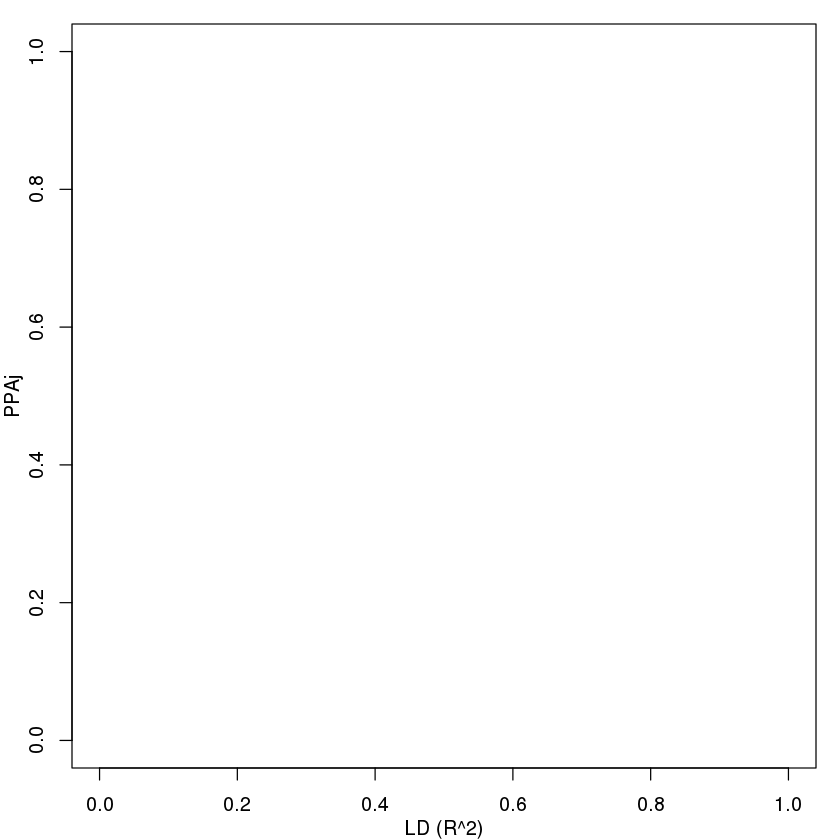

In [112]:
heatmap_tests = function(tests, breaks)
{
    par(mar = c(3,3,1,1))
    plot(1,1, type = "n", xlim = c(0,1), ylim = c(0,1), xlab = "", ylab = "")
    mtext(text = "LD (R^2)", side = 1, line = 2)
    mtext(text = "PPAj"    , side = 2, line = 2)
    
    rect(xleft = tests$)
    
}

heatmap_tests(tests_all, breaks)


In [111]:
tests_all

name,ld,pp,ldh_pph,ldh_ppl,ldl_pph,ldl_ppl,pval,or,ci05,ci95
all,0.0,0.0,6821,0,0,0,1.000000000,0.000000,0.00000000,Inf
all,0.1,0.0,4654,0,2167,0,1.000000000,0.000000,0.00000000,Inf
all,0.2,0.0,3922,0,2899,0,1.000000000,0.000000,0.00000000,Inf
all,0.3,0.0,3358,0,3463,0,1.000000000,0.000000,0.00000000,Inf
all,0.4,0.0,2900,0,3921,0,1.000000000,0.000000,0.00000000,Inf
all,0.5,0.0,2458,0,4363,0,1.000000000,0.000000,0.00000000,Inf
all,0.6,0.0,2023,0,4798,0,1.000000000,0.000000,0.00000000,Inf
all,0.7,0.0,1595,0,5226,0,1.000000000,0.000000,0.00000000,Inf
all,0.8,0.0,1197,0,5624,0,1.000000000,0.000000,0.00000000,Inf
all,0.9,0.0,716,0,6105,0,1.000000000,0.000000,0.00000000,Inf


In [99]:
snp2max$ld_high = FALSE
snp2max$pp_high = FALSE
snp2max$pp_med  = FALSE
snp2max$pp_mhi  = FALSE

snp2max[snp2max$ld   > 0.8, "ld_high"] = TRUE
snp2max[snp2max$PPAj > 0.8, "pp_high"] = TRUE
snp2max[snp2max$PPAj > 0.1 & snp2max$PPAj < 0.8, "pp_med"] = TRUE
snp2max[snp2max$PPAj > 0.1, "pp_mhi"] = TRUE

write.table(snp2max, "cpbayes_snp2max.txt", quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)

In [99]:
nrow(snp2max[snp2max$pp_high == TRUE,])/ nrow(snp2max)

#table(snp2max[,c("ld_high", "pp_high")])
#table(snp2max[,c("ld_high", "pp_med" )])
fisher.test(table(snp2max[,c("ld_high", "pp_high")]))
#fisher.test(table(snp2max[,c("ld_high", "pp_med" )]))
fisher.test(table(snp2max[,c("ld_high", "pp_mhi" )]))

#table(snp2max[snp2max$svtype == "STR",c("ld_high", "pp_high")])
#table(snp2max[snp2max$svtype == "STR",c("ld_high", "pp_med" )])
fisher.test(table(snp2max[snp2max$svtype == "STR",c("ld_high", "pp_high")]))
#fisher.test(table(snp2max[snp2max$svtype == "STR",c("ld_high", "pp_med" )]))
fisher.test(table(snp2max[snp2max$svtype == "STR",c("ld_high", "pp_mhi" )]))

#table(snp2max[snp2max$svtype != "STR",c("ld_high", "pp_high")])
#table(snp2max[snp2max$svtype != "STR",c("ld_high", "pp_med" )])
fisher.test(table(snp2max[snp2max$svtype != "STR",c("ld_high", "pp_high")]))
#fisher.test(table(snp2max[snp2max$svtype != "STR",c("ld_high", "pp_med" )]))
fisher.test(table(snp2max[snp2max$svtype != "STR",c("ld_high", "pp_mhi" )]))

[1] 0.01612667


	Fisher's Exact Test for Count Data

data:  table(snp2max[, c("ld_high", "pp_high")])
p-value = 0.03183
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.009653 2.526435
sample estimates:
odds ratio 
  1.618674 



	Fisher's Exact Test for Count Data

data:  table(snp2max[, c("ld_high", "pp_mhi")])
p-value = 0.006095
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.150673 2.368236
sample estimates:
odds ratio 
  1.663793 



	Fisher's Exact Test for Count Data

data:  table(snp2max[snp2max$svtype == "STR", c("ld_high", "pp_high")])
p-value = 0.01845
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.065052 2.877263
sample estimates:
odds ratio 
  1.775333 



	Fisher's Exact Test for Count Data

data:  table(snp2max[snp2max$svtype == "STR", c("ld_high", "pp_mhi")])
p-value = 0.00687
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.154425 2.566664
sample estimates:
odds ratio 
  1.736802 



	Fisher's Exact Test for Count Data

data:  table(snp2max[snp2max$svtype != "STR", c("ld_high", "pp_high")])
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1697789 3.1373671
sample estimates:
odds ratio 
 0.9063308 



	Fisher's Exact Test for Count Data

data:  table(snp2max[snp2max$svtype != "STR", c("ld_high", "pp_mhi")])
p-value = 0.4863
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4836828 3.1291325
sample estimates:
odds ratio 
  1.322553 


In [92]:
aggregate(ld ~ ld_high, data = snp2max, FUN = length)
aggregate(ld ~ ld_high, data = snp2max, FUN = mean)
aggregate(ld ~ ld_high, data = snp2max, FUN = median)
aggregate(ld ~ ld_high, data = snp2max, FUN = function(x){quantile(x, probs = 0.25)})
aggregate(ld ~ ld_high, data = snp2max, FUN = function(x){quantile(x, probs = 0.75)})


ld_high,ld
FALSE,5624
TRUE,1197


ld_high,ld
FALSE,0.2634644
TRUE,0.9098329


ld_high,ld
FALSE,0.1865163
TRUE,0.9169966


ld_high,ld
FALSE,0.02943744
TRUE,0.86458056


ld_high,ld
FALSE,0.4685371
TRUE,0.9568398


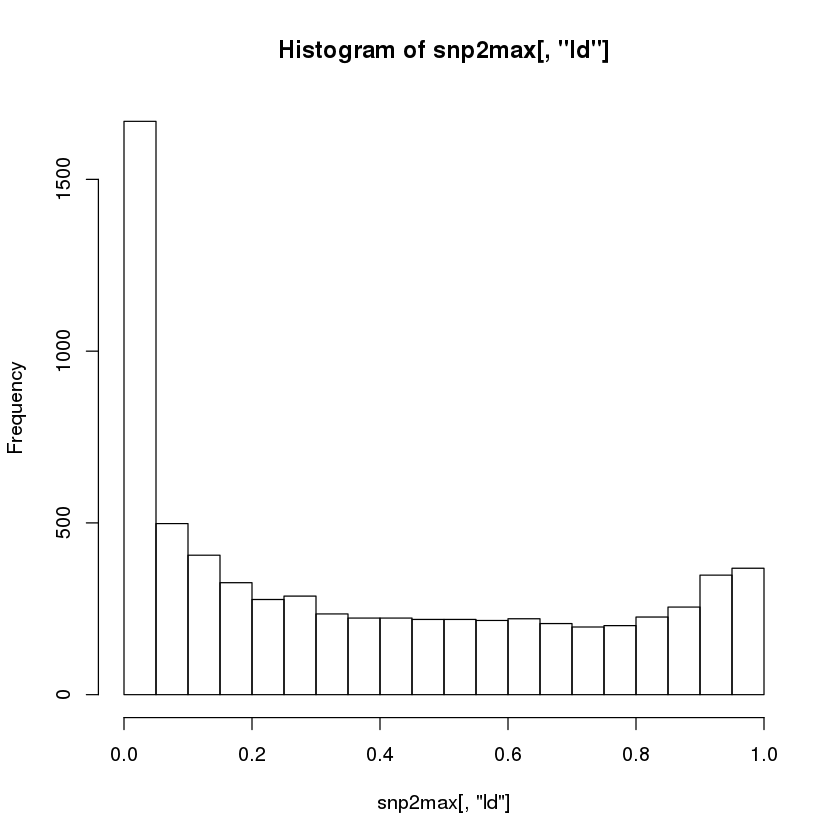

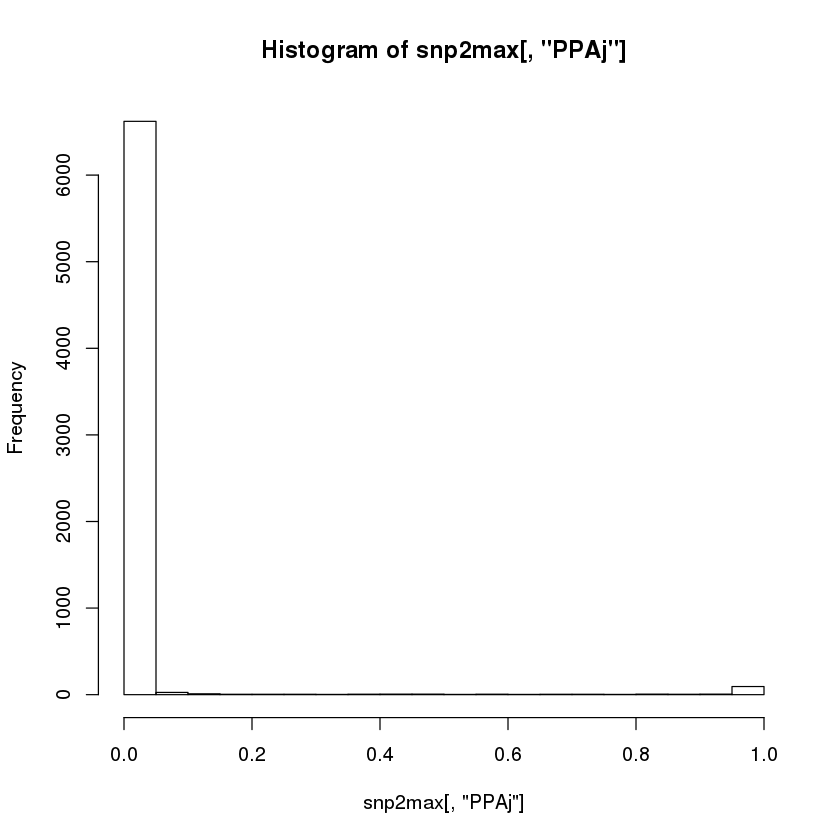

In [100]:
hist(snp2max[, "ld"  ], breaks = c(0:20)/20)
hist(snp2max[, "PPAj"], breaks = c(0:20)/20)


In [66]:
28/(1169+28)
82/(5542+82)

[1] 0.02339181

[1] 0.01458037

In [115]:
nrow(snp2max[snp2max$ld > 0.8 & snp2max$PPAj > 0.8, ])
nrow(snp2max[snp2max$ld > 0.8 & snp2max$PPAj > 0.8 & snp2max$svtype == "STR", ])


[1] 28

[1] 25

In [59]:
str(snp2max)

'data.frame':	6821 obs. of  27 variables:
 $ id2gene    : chr  "10_100025816_G_A ENSG00000166024.9" "10_100172479_A_G ENSG00000119943.6" "10_101625549_C_T ENSG00000107554.11" "10_101999097_G_T ENSG00000196072.7" ...
 $ ld         : num  0.8554 0.0892 0.945 0.5752 0.1035 ...
 $ PPAj       : num  0.0004 0.0004 0.0006 0.0006 0.0002 0.035 0.0004 0.0004 0.0002 0.0004 ...
 $ feature_id : chr  "ENSG00000166024" "ENSG00000119943" "ENSG00000107554" "ENSG00000196072" ...
 $ sv_id      : chr  "DEL_10_100025136_100025453" "Human_STR_184378" "Human_STR_185255" "Human_STR_185604" ...
 $ svtype     : chr  "DEL" "STR" "STR" "STR" ...
 $ sv_start   : int  100025136 100104298 101613588 102026581 101526848 102302938 102677677 102696075 104177916 103170459 ...
 $ sv_end     : int  100025453 100104313 101613627 102026625 101526869 102302960 102677698 102696109 104177944 103170473 ...
 $ pval_svonly: num  5.49e-13 3.93e-06 1.77e-04 1.04e-17 6.42e-04 ...
 $ beta_svonly: num  -0.2838 0.222 0.24 0.2445 -0.0884

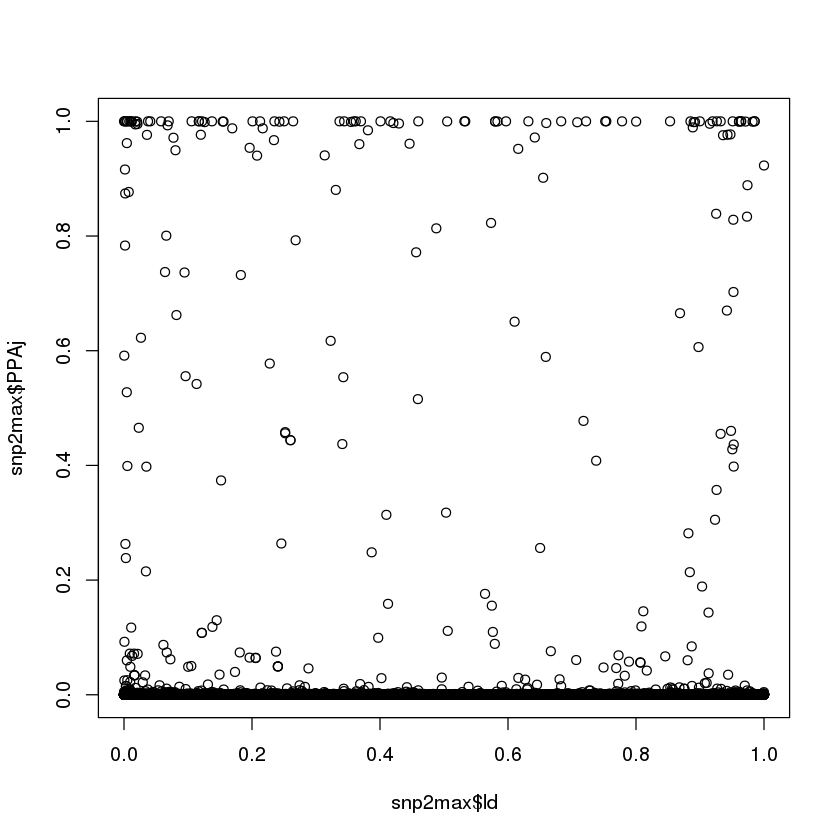

In [62]:
plot(snp2max$ld, snp2max$PPAj)

In [37]:
nrow(eqtls_sv[eqtls_sv$id2gene %in% tested$id2gene,])

[1] 5367

In [48]:
str(over)

'data.frame':	5615 obs. of  32 variables:
 $ feature_id  : chr  "ENSG00000166024" "ENSG00000119943" "ENSG00000196072" "ENSG00000075826" ...
 $ traits      : chr  "10_100025816_G_A" "10_100172479_A_G" "10_101999097_G_T" "10_102295658_T_G" ...
 $ poste_mean  : num  -0.326 -0.798 0.721 0.157 0.313 ...
 $ poste_median: num  -0.326 -0.798 0.721 0.157 0.313 ...
 $ poste_se    : num  0.0396 0.0439 0.0567 0.0262 0.0287 ...
 $ lCl         : num  -0.402 -0.883 0.611 0.107 0.257 ...
 $ uCl         : num  -0.248 -0.711 0.833 0.209 0.369 ...
 $ PPAj        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ top         : chr  "10_100025816_G_A" "10_100172479_A_G" "10_101999097_G_T" "10_102295658_T_G" ...
 $ sv_id       : chr  "DEL_10_100025136_100025453" "Human_STR_184378" "Human_STR_185604" "Human_STR_185841" ...
 $ svtype      : chr  "DEL" "STR" "STR" "STR" ...
 $ pval_svonly : num  5.49e-13 3.93e-06 1.04e-17 2.16e-08 4.05e-12 ...
 $ beta_svonly : num  -0.284 0.222 0.245 -0.117 0.351 ...
 $ se_svonly   : num  0.03